In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(kernlab)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(doParallel)))
suppressWarnings(suppressMessages(library(pROC)))

In [2]:
roclist <- list()
results <- tibble(model = character(), accuracy = double(), auc = double())

## Question 1

In [3]:
dtrain <- read.csv("Hitters_train.csv",row.names=1)
dval <- read.csv("Hitters_test.csv",row.names=1)

names_train <- rownames(dtrain)
names_test <- rownames(dval)

dtrain <- dtrain %>% mutate(Salary = as.factor(Salary))
dval <- dval %>% mutate(Salary = as.factor(Salary))

## Question 2

In [4]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

glm_1 <- caret::train(
    Salary~., data = dtrain, method = 'glm',
    trControl = trainControl("none")
)
on.exit(stopCluster(cl))

glm_1

Generalized Linear Model 

132 samples
 20 predictor
  2 classes: 'high', 'low' 

No pre-processing
Resampling: None 

In [5]:
test <- pull(dval, Salary) %>% as.numeric
pred <- predict(glm_1, newdata = select(dval, -Salary)) %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['glm']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'glm', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Risque moyen:', 1 - acc,
    '\nValidation AUC: ', rc$auc
))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Setting levels: control = 1, case = 2
Setting direction: controls < cases


Risque moyen: 0.213740458015267 
Validation AUC:  0.784748134328358

## Question 3

In [6]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

knn_1 <- caret::train(
    Salary~., data = dtrain, method = 'knn',
    trControl = trainControl("cv", number = 5, repeats = 5, allowParallel = T),
    tuneGrid = expand.grid(k = 1:100)
)

result <- tibble(k = numeric(), Rempirique = double())
for (k in 1:100){
    y_pred <- class::knn(select(dtrain, -Salary), select(dtrain, -Salary), cl = pull(dtrain, Salary), k = k)
    risk <- mean((pull(dtrain, Salary) != y_pred))
    result <- result  %>% bind_rows(tibble(
        k = k, Rempirique = risk
    ))
}
on.exit(stopCluster(cl))

Warning message:
"`repeats` has no meaning for this resampling method."

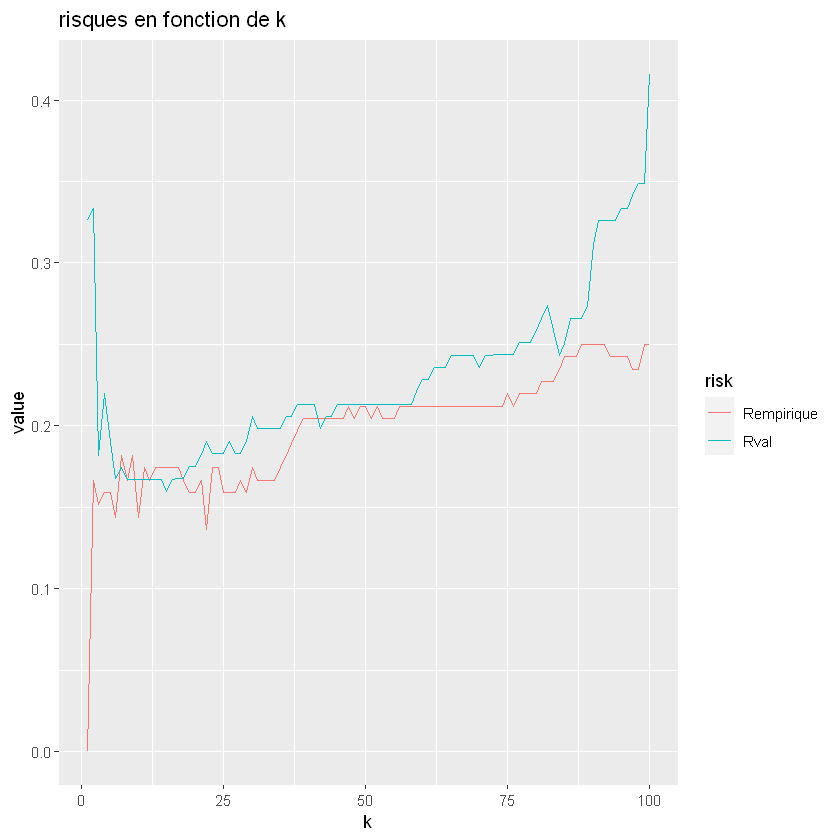

In [7]:
knn_1$results %>% mutate(Rval = 1-Accuracy) %>% 
select(Rval) %>% bind_cols(result) %>% gather(risk, value, -k) %>% 
ggplot() + aes(k, value, color = risk) + geom_line() + 
ggtitle("risques en fonction de k")

In [8]:
pred <- predict(knn_1, newdata = select(dval, -Salary)) %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['knn']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'knn', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Risque moyen:', 1 - acc,
    '\nValidation AUC: ', rc$auc
))

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Risque moyen: 0.137404580152672 
Validation AUC:  0.863922574626866

## Question 4

In [9]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

svm_1 <- caret::train(
    Salary~., data = dtrain, method = 'svmLinear',
    trControl = trainControl("cv", number = 5, repeats = 5, allowParallel = T),
    tuneGrid = expand.grid(C = seq(.001, 1.001, by = .01))
)
on.exit(stopCluster(cl))

Warning message:
"`repeats` has no meaning for this resampling method."

In [10]:
c <- svm_1$finalModel@param$C
alpha_i <- svm_1$finalModel@alpha[[1]]
index <- svm_1$finalModel@alphaindex[[1]]

cat('Entre les frontières:')
cat(names_train[index[which(alpha_i == c)]])

Entre les frontières:-Alan Ashby -Andres Galarraga -Alex Trevino -Andy VanSlyke -Bill Almon -Chris Brown -Carney Lansford -Craig Reynolds -Cal Ripken -Chris Speier -Dave Concepcion -Damaso Garcia -Dan Gladden -Dave Henderson -Don Slaught -Darryl Strawberry -Eddie Milner -George Bell -Greg Brock -Glenn Hubbard -Graig Nettles -Gary Pettis -Gary Redus -Greg Walker -Gary Ward -Hubie Brooks -Hal McRae -Jose Canseco -Joe Carter -Julio Franco -Jim Gantner -Johnny Grubb -Jeffrey Leonard -Jim Morrison -Jim Presley -Joel Youngblood -Kevin Bass -Ken Landreaux -Kevin McReynolds -Ken Oberkfell -Larry Herndon -Lou Whitaker -Mel Hall -Mike Heath -Mike Marshall -Mike Pagliarulo -Oddibe McDowell -Ozzie Virgil -Paul Molitor -Pat Tabler -Rick Burleson -Rick Cerone -Ron Hassey -Rick Manning -Rance Mulliniks -Rafael Ramirez -Robby Thompson -Scott Fletcher -Steve Sax -Tony Fernandez -Wally Joyner -Wayne Tolleson

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Risque moyen: 0.16030534351145 
Test AUC:  0.839435634328358

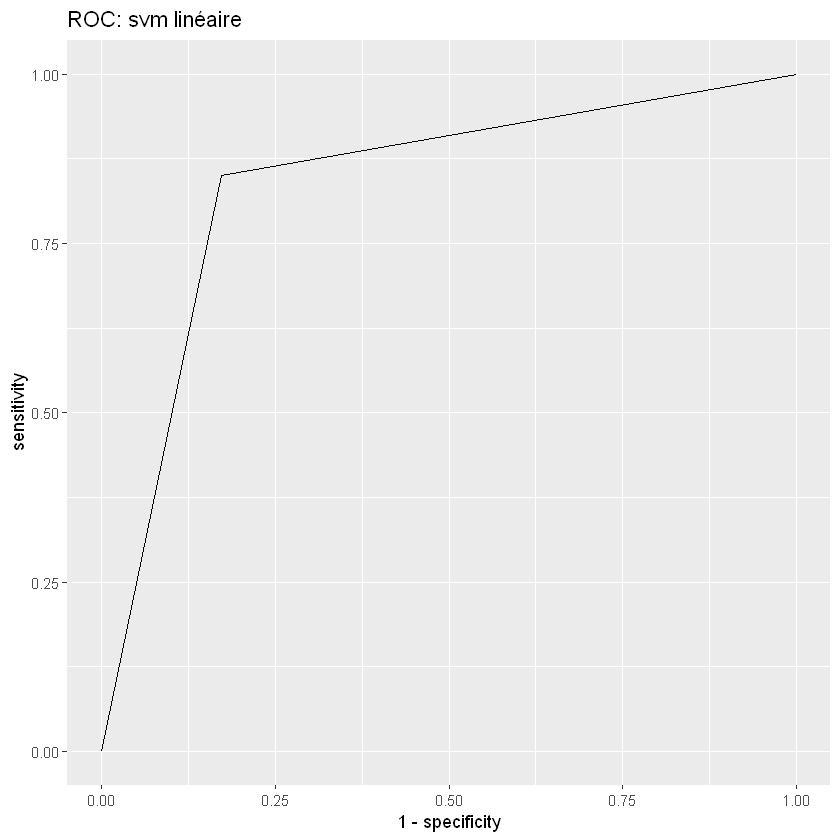

In [26]:
pred <- predict(svm_1$finalModel, newdata = select(dval, -Salary)) %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['svmLinear']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'svmLinear', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Risque moyen:', 1 - acc,
    '\nTest AUC: ', rc$auc
))

ggroc(rc, legacy.axes = T) +
ggtitle("ROC: svm linéaire")

## Question 5

In [12]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

svm_2 <- caret::train(
    Salary~., data = dtrain, method = 'svmRadial',
    trControl = trainControl("cv", number = 5, allowParallel = T),
    tuneGrid = expand.grid(sigma = seq(0, 1, by = .2), C = seq(.01, 1, by = .09))
)

c <- svm_2$finalModel@param$C
result <- tibble(sigma = numeric(), Rempirique = double())
for (s in seq(0, 1, by = .2)){
    model <- kernlab::ksvm(Salary~.,data=dtrain,scaled=FALSE,type="C-svc",kernel="rbfdot",kpar=list(sigma=0.001),C=c)
    result <- result  %>% bind_rows(tibble(
        sigma = s, Rempirique = model@error
    ))
}


on.exit(stopCluster(cl))

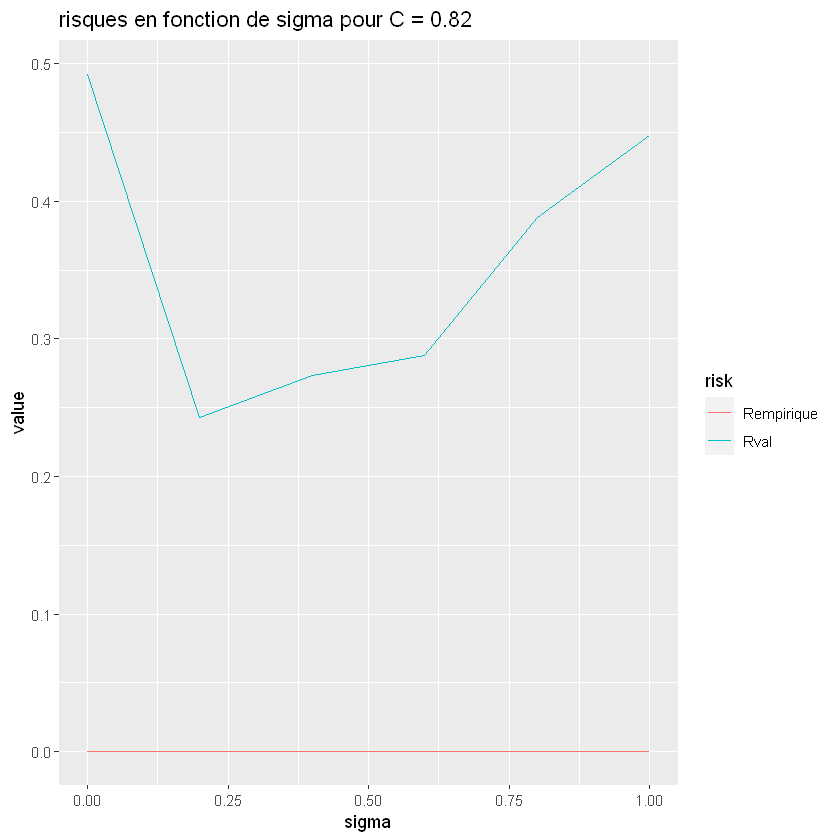

In [13]:
svm_2$results %>% filter(C == c) %>% 
mutate(Rval = 1-Accuracy) %>% select(Rval) %>% 
bind_cols(result) %>% gather(risk, value, - sigma) %>% 
ggplot()+ aes(sigma, value, color = risk) + geom_line() + 
ggtitle(paste("risques en fonction de sigma pour C =", c))

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Risque moyen: 0.206106870229008 
Validation AUC:  0.796408582089552

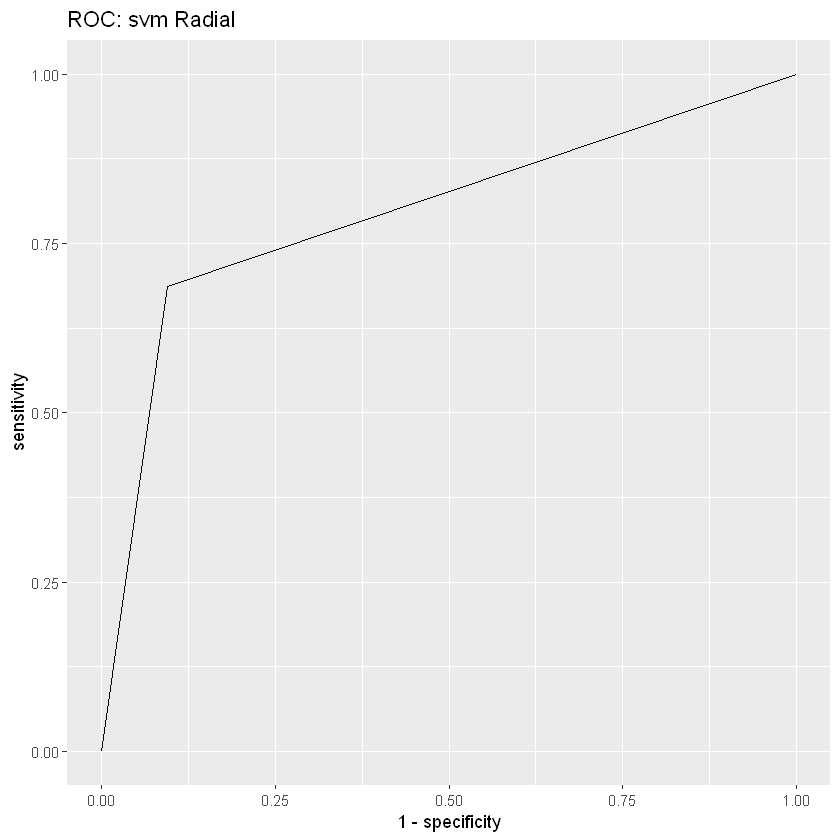

In [27]:
pred <- predict(svm_2$finalModel, newdata = select(dval, -Salary)) %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['svmRadial']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'svmRadial', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Risque moyen:', 1 - acc,
    '\nValidation AUC: ', rc$auc
))

ggroc(rc, legacy.axes = T) +
ggtitle("ROC: svm Radial")

## Question 6

In [15]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

rf_1 <- caret::train(
    Salary~., data = dtrain, method = 'ranger', importance = 'impurity_corrected',
    trControl = trainControl(method = "oob", allowParallel = T),
    tuneGrid = expand.grid(
        mtry = seq(1, length(dtrain)-1),
        splitrule = "gini", min.node.size = 1
    )
)
on.exit(stopCluster(cl))

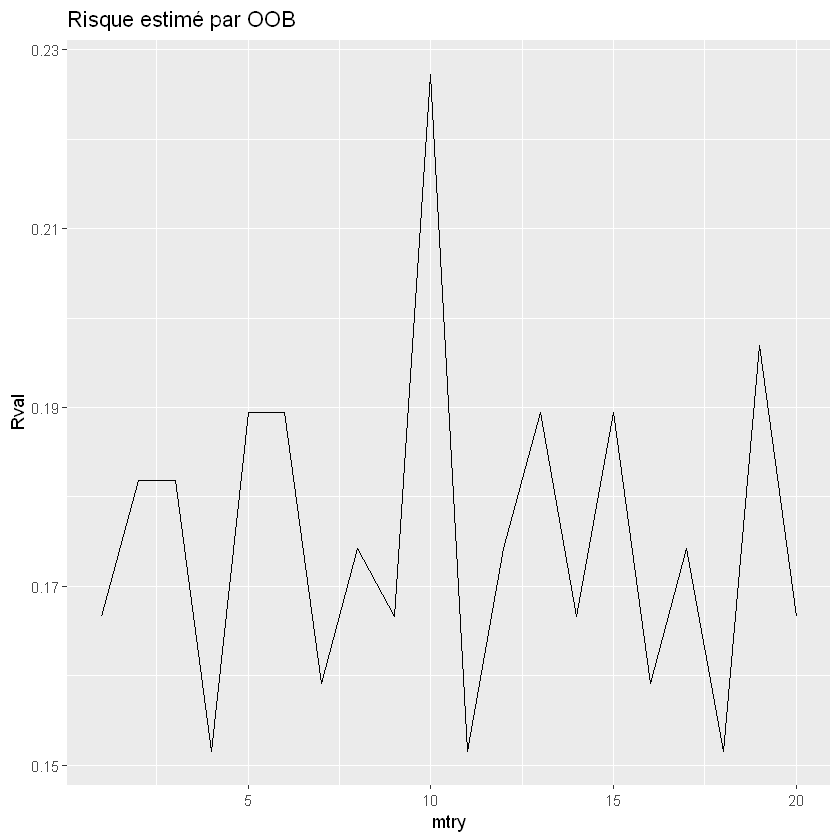

In [16]:
rf_1$results %>% mutate(Rval = 1-Accuracy) %>% 
ggplot() + aes(x = mtry, y = Rval) + 
geom_line() +
ggtitle('Risque estimé par OOB')

Warning message in predict.ranger(rf_1$finalModel, data = select(dval, -Salary)):
"Forest was grown with 'impurity_corrected' variable importance. For prediction it is advised to grow another forest without this importance setting."Setting levels: control = 1, case = 2
Setting direction: controls < cases


Risque moyen: 0.114503816793893 
Test AUC:  0.885960820895522

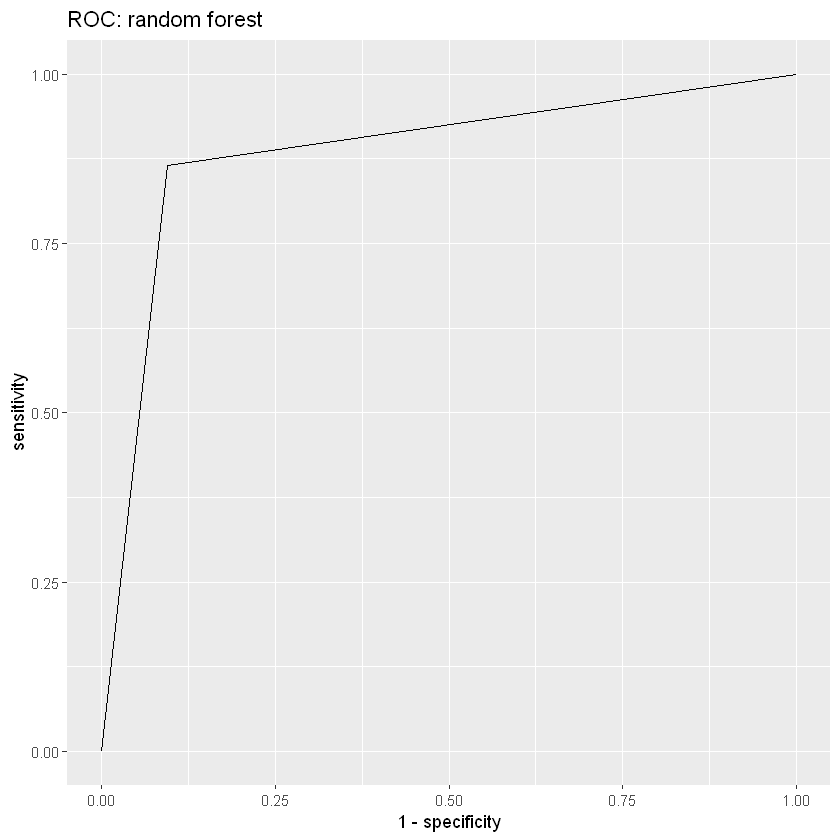

In [28]:
pred <- predict(rf_1$finalModel, data = select(dval, -Salary))$prediction %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['RF']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'RF', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Risque moyen:', 1-acc,
    '\nTest AUC: ', rc$auc
))

ggroc(rc, legacy.axes = T) +
ggtitle("ROC: random forest")

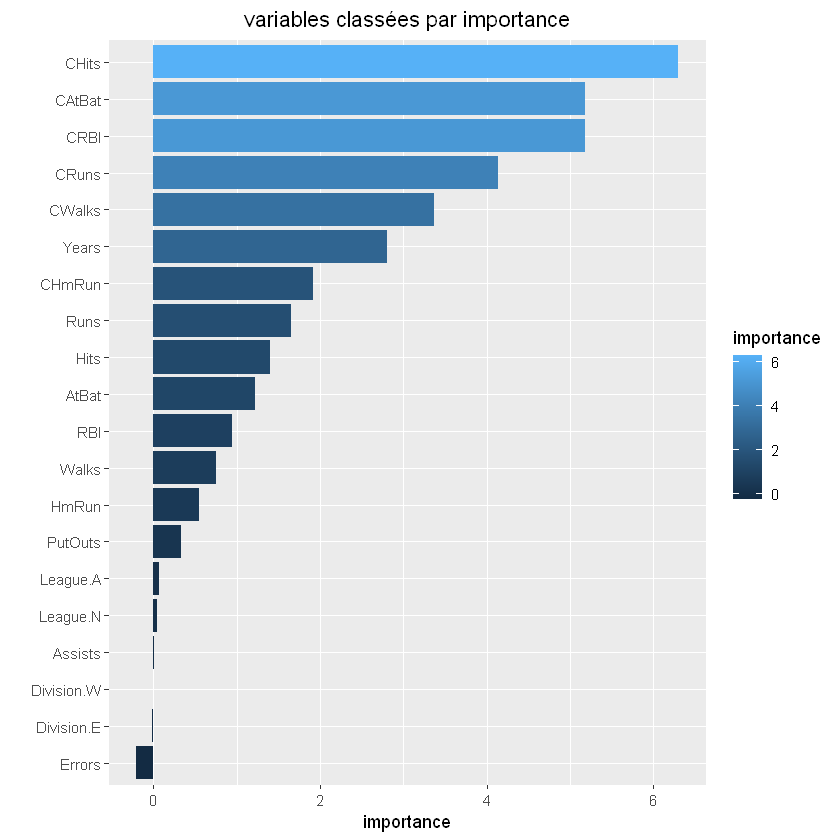

In [18]:
rf_naive_vars <- rf_1$finalModel$variable.importance
rf_naive_vars <- tibble(variable = names(rf_naive_vars), importance = rf_naive_vars) %>% 
    arrange(importance) %>% mutate(variable = factor(variable, levels = variable))

ggplot(rf_naive_vars) + coord_flip() + 
  aes(x = variable, y = importance, fill = importance) + geom_bar(stat = "identity") + 
  labs(title = "variables classées par importance", x = "") +
  theme(plot.title = element_text(hjust = 0.5))

## Question 7

In [19]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

xgb_1 <- caret::train(
    Salary~., data = dtrain, method = 'xgbTree',
    trControl = trainControl("cv", number = 5, allowParallel = T),
    tuneGrid = expand.grid(
        nrounds = seq(1, 100, by=10), eta = c(.025, .05, .1, .2),
        max_depth = c(2,4,6), gamma = c(0, .05, .1, .5, .75, 1),
        colsample_bytree = 1, min_child_weight = 1, subsample = 1
    )
)
on.exit(stopCluster(cl))

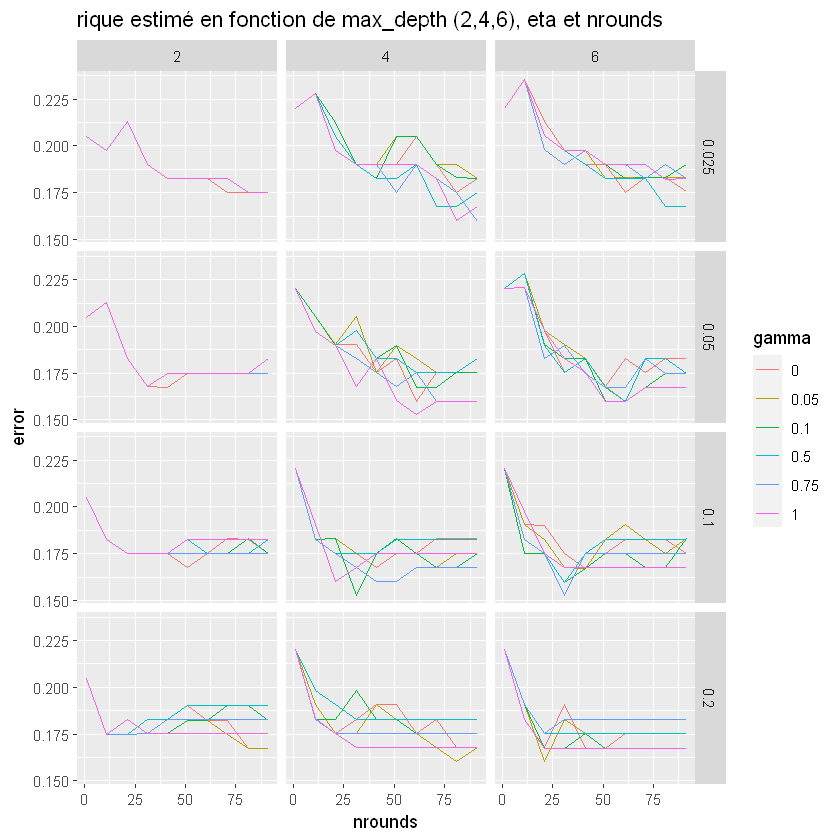

In [20]:
xgb_1$results %>% 
mutate(
    eta = as.factor(eta),
    max_depth = as.factor(max_depth),
    gamma = as.factor(gamma),
    error = 1-Accuracy
) %>% ggplot() + aes(nrounds, error, color = gamma) +
geom_line() + facet_grid(eta~max_depth) +
ggtitle('rique estimé en fonction de max_depth (2,4,6), eta et nrounds')

Setting levels: control = 1, case = 2
Setting direction: controls < cases


Risque moyen: 0.114503816793893 
Test AUC:  0.885611007462687

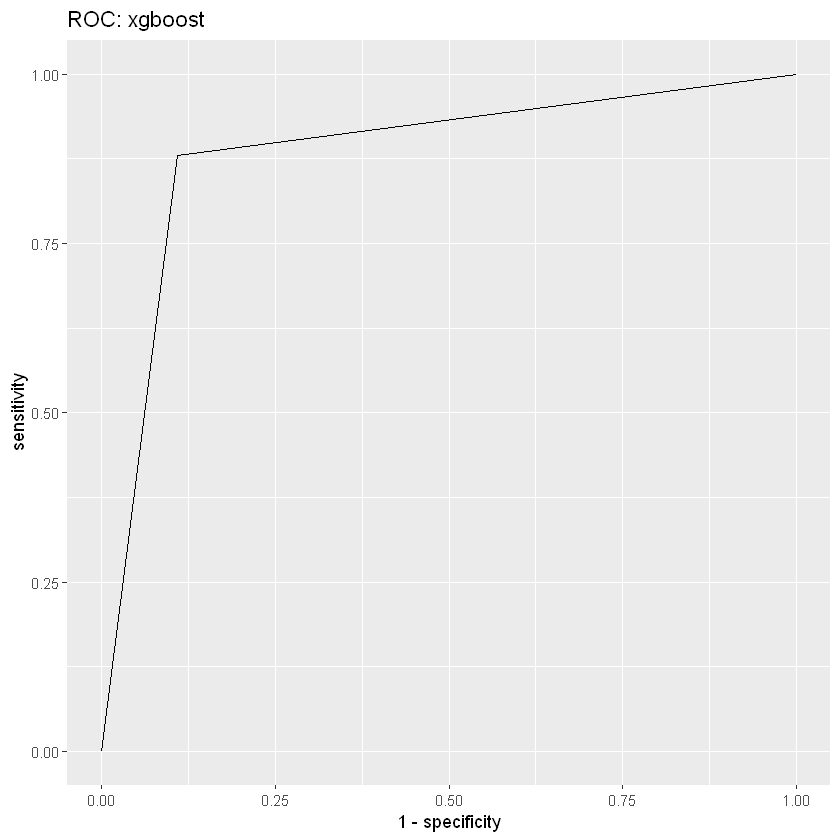

In [29]:
pred <- (predict(xgb_1$finalModel, newdata = select(dval, -Salary) %>% as.matrix) < .5) %>% as.factor %>% as.numeric
acc <- 1 - mean(pred != test)
rc <- roc(test, pred)
roclist[['xgboost']] <- rc
results <- results %>% bind_rows(
    tibble(model = 'xgboost', accuracy = acc, auc = rc$auc %>% as.double)
)

cat(paste(
    'Risque moyen:', 1-acc,
    '\nTest AUC: ', rc$auc
))

ggroc(rc, legacy.axes = T) +
ggtitle("ROC: xgboost")

## Question 8
Lors de l'apprentissage on a utilisé le risque estimé par validation pour choisir nos meilleurs hyperparamètres.  
Pour choisir le meilleur modèle, on a aussi introduit le score AUC (~ courbe ROC).

Les forêts aléatoires et xgboost ayant sensiblement les même performance d'après leur accuracy, leur AUC permet de les départager. On choisira xgboost si on se fie à l'AUC.

model,accuracy,auc
glm,0.7862595,0.7847481
knn,0.8625954,0.8639226
svmLinear,0.8396947,0.8394356
svmRadial,0.7938931,0.7964086
RF,0.8854962,0.8859608
xgboost,0.8854962,0.8856110


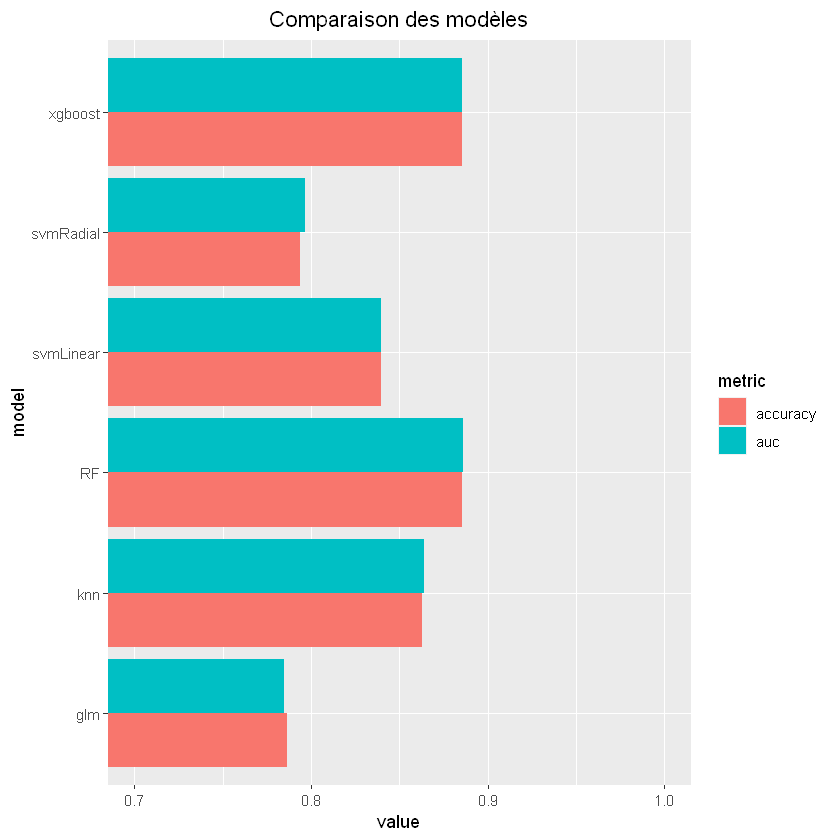

In [24]:
results

results %>% 
gather(metric, value, -model) %>% 
ggplot() +
aes(fill = metric, y = value, x = model) +
geom_bar(position = "dodge", stat = "identity") +
coord_flip(ylim = c(.7, 1)) +
labs(title = "Comparaison des modèles") +
theme(plot.title = element_text(hjust = 0.5))

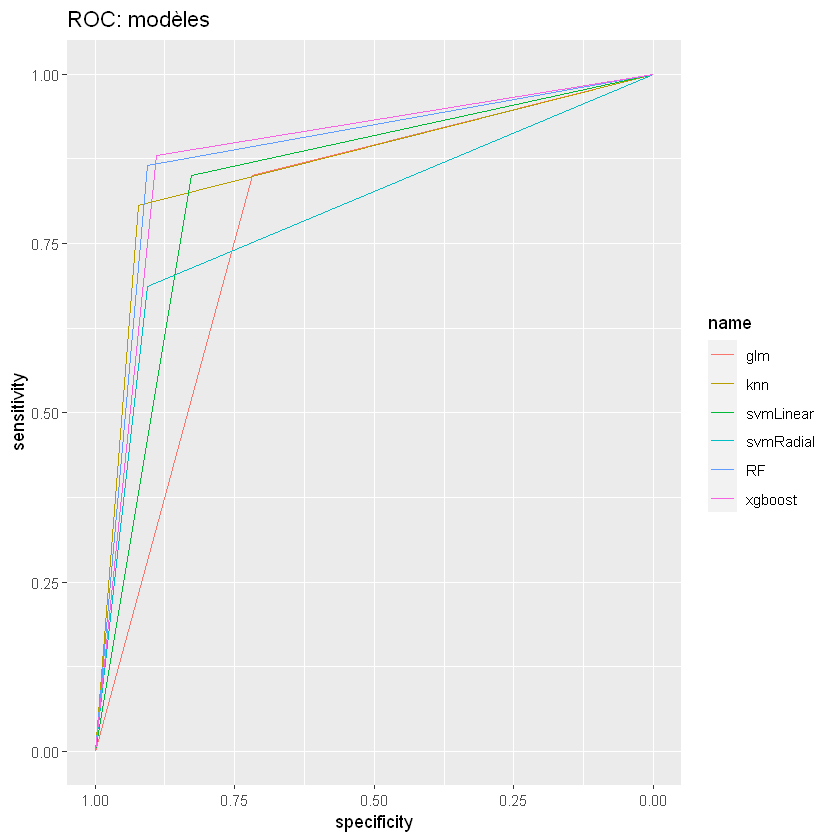

In [30]:
ggroc(roclist) +
ggtitle("ROC: modèles")